DB Index: 1.5760671419284606
Silhouette Score: 0.22802093805827678
Calinski-Harabasz Index: 42.91590970167104


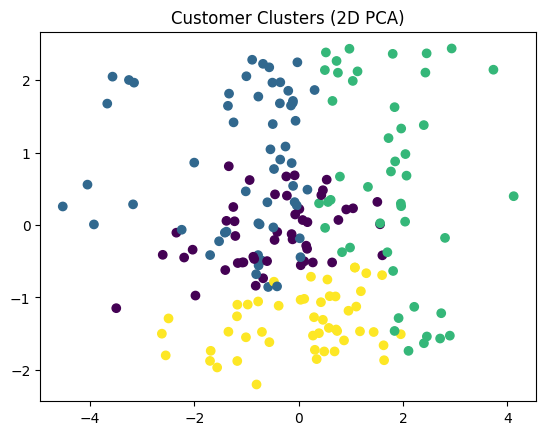

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Clustering


# Visualization


In [23]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

In [24]:

data = pd.merge(transactions, customers, on='CustomerID')
data = pd.merge(data, products, on='ProductID')

# Feature engineering
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['SignupDate'] = pd.to_datetime(data['SignupDate'])
data['DaysSinceSignup'] = (pd.Timestamp.now() - data['SignupDate']).dt.days
data['DaysSinceLastTransaction'] = (pd.Timestamp.now() - data.groupby('CustomerID')['TransactionDate'].transform('max')).dt.days

customer_features = data.groupby('CustomerID').agg(
    TotalTransactions=('TransactionID', 'count'),
    TotalSpent=('Price_x', 'sum'),
    AvgTransactionValue=('Price_x', 'mean'),
    DaysSinceSignup=('DaysSinceSignup', 'first'),
    DaysSinceLastTransaction=('DaysSinceLastTransaction', 'first'),
    Region=('Region', 'first')
).reset_index()

In [25]:
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

In [26]:
customer_features

,CustomerID,TotalTransactions,TotalSpent,AvgTransactionValue,DaysSinceSignup,DaysSinceLastTransaction,Region_Europe,Region_North America,Region_South America
0,C0001,5,1391.67,278.334000,933,86,False,False,True
1,C0002,4,835.68,208.920000,1080,56,False,False,False
2,C0003,4,782.83,195.707500,327,156,False,False,True
3,C0004,8,1925.09,240.636250,842,36,False,False,True
4,C0005,3,874.81,291.603333,897,85,False,False,False
...,...,...,...,...,...,...,...,...,...
194,C0196,4,1667.97,416.992500,966,44,True,False,False
195,C0197,3,681.17,227.056667,679,31,True,False,False
196,C0198,2,479.41,239.705000,1066,115,True,False,False
197,C0199,4,1002.44,250.610000,787,94,True,False,False


In [27]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop('CustomerID', axis=1))

In [28]:
scaled_features

array([[-0.01145819,  0.03332559,  0.09467022, ..., -0.57928445,
        -0.54831888,  1.54041597],
       [-0.46749414, -0.80691867, -0.90401592, ..., -0.57928445,
        -0.54831888, -0.6491753 ],
       [-0.46749414, -0.88678865, -1.09410928, ..., -0.57928445,
        -0.54831888,  1.54041597],
       ...,
       [-1.37956603, -1.34533451, -0.46110018, ...,  1.72626765,
        -0.54831888, -0.6491753 ],
       [-0.46749414, -0.55490131, -0.30420572, ...,  1.72626765,
        -0.54831888, -0.6491753 ],
       [-0.01145819,  0.17063848,  0.35611784, ..., -0.57928445,
        -0.54831888, -0.6491753 ]])

In [29]:
sse = []

for i in range(2,11):
  curr = KMeans(n_clusters=i, random_state=42)
  curr.fit(scaled_features)
  sse.append(curr.inertia_)

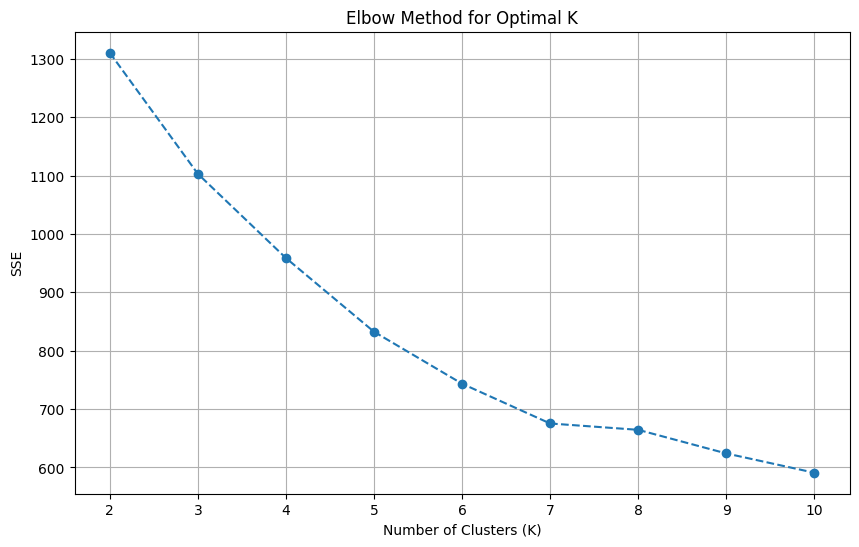

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.xticks(range(2,11))
plt.grid()
plt.show()

In [33]:
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Evaluation
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette = silhouette_score(scaled_features, clusters)
calinski = calinski_harabasz_score(scaled_features, clusters)

print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski}")

DB Index: 1.3192518309035433
Silhouette Score: 0.24245181115494707
Calinski-Harabasz Index: 43.43011872268251


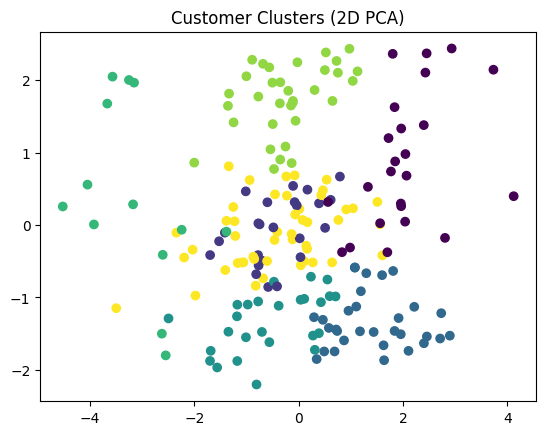

In [34]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('Customer Clusters (2D PCA)')
plt.show()